In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
orders = pd.read_csv("../Downloads/bl_data/bl_fulfillment_orders.csv", parse_dates = ["created_at"])
order_states = pd.read_csv("../Downloads/bl_data/bl_fulfillment_order_states.csv", parse_dates = ["created_at"])
order_items = pd.read_csv("../Downloads/bl_data/bl_fulfillment_order_items.csv", parse_dates = ["created_at"])

## Examining Orders with Multiple Items

My goal is to examine orders with multiple items.  First, I will plot the distribution of order sizes to get an idea of how many items make up a single order.  I will then count all pairings of items in orders of size > 1.  This can be used to find the most common pairings, which might help in figuring out where items should be stocked in a warehouse.  Items that are commonly ordered together should be near one another to minimize the distance one needs to cover to retrieve them.  I will also be able to find the most common pairings for a given item.  This can be useful for surfacing recommendations based on what a user is currently looking at.

In [3]:
orders_placed = orders[~orders["state"].isin(["cancelled", "open_order"])]

order_items_placed = order_items[order_items["order_id"].isin(orders_placed["id"].to_list())]
item_list = np.unique(order_items_placed["product_id"])
pair_dict = {k: [] for k in item_list}
items_per_order = order_items_placed[["order_id","product_id"]].groupby("order_id")["product_id"].apply(list)
for i in items_per_order.index:
    items = np.unique(items_per_order.loc[i])
    for j in range(len(items)-1):
        for k in range(j+1, len(items)):
            it1 = items[j]
            it2 = items[k]
            if it2 < it1:
                tmp = it1
                it1 = it2
                it2 = tmp
            pair_dict[it1].append(it2)

bb_orders = orders_placed[orders_placed["order_type"]=="hello_baby_box"]["id"].to_list()
items_per_order_nobb = items_per_order[~np.isin(list(items_per_order.index), bb_orders)]

order_sizes_nobb = np.array(items_per_order_nobb.apply(len))
ord_unq = np.unique(order_sizes_nobb, return_counts=True)

## Distribution of Order Size

Below, I've plotted the distribution of order sizes (i.e. number of items in each order).  I exclude orders that have a state of cancelled or open_order, as well as orders of type hello_baby_box.  Around 70% of orders are for a single item, meaning that 30% of orders contain multiple items.

Text(0.5, 1.0, 'Distribution of order size')

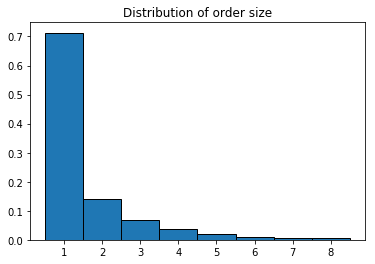

In [4]:
plt.hist(order_sizes_nobb, bins=[.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5], edgecolor="black", density=True)
plt.title("Distribution of order size")

In [5]:
labels = ["1", "2", "3", "4", "5", "6", "7", "8+"]
dat = np.concatenate([ord_unq[1][0:7], [np.sum(ord_unq[1][7:])]])
order_dist = pd.DataFrame(index=labels, data={"num_orders":dat})
order_dist["proportion"] = order_dist["num_orders"] / np.sum(order_dist["num_orders"])
order_dist

,num_orders,proportion
1,244089,0.704425
2,48274,0.139316
3,23374,0.067456
4,12163,0.035102
5,6459,0.018640
6,3889,0.011223
7,2472,0.007134
8+,5788,0.016704


In [6]:
pairings = {}
for i in pair_dict:
    its = pair_dict[i]
    for j in its:
        pair = (i, j)
        if (i, j) in pairings:
            pairings[(i, j)] += 1
        else:
            pairings[(i, j)] = 1

pairings = pd.Series(pairings)
pairings.sort_values(ascending=False, inplace=True)
pairings = pd.DataFrame(pairings)
pairings.rename({0:"num_orders"},axis="columns",inplace=True)
pairings.index.names = ["item_1","item_2"]

prod_dict = {}
for i in order_items.index:
    prod_dict[order_items.loc[i, "product_id"]] = order_items.loc[i, "name"]

## Pairs of Items Ordered Together

I am interested in which items are most often ordered together.  I've counted the number of times each pair of items appears in an order.  For example, if you were to order a diaper, a bottle, and a book then the pairs (diaper, bottle), (bottle, book), and (diaper, book) would each be counted once.  Below, I list the top ten item pairs and how many orders each pairing appears in.

In [7]:
for i in pairings.head(n=10).index:
    it1 = prod_dict[i[0]]
    it2 = prod_dict[i[1]]
    print(it1 + " & " + it2 + ": " + str(pairings.loc[i,"num_orders"]))
    print("")

Boppy Bare Naked Nursing Pillow and Positioner & Boppy Water Resistant Protective Cover: 768

Boon Lawn Countertop Drying Rack - Green & Boon Drying Rack Accessory (Twig) - White: 517

The Very Hungry Caterpillar & Goodnight Moon: 401

The Very Hungry Caterpillar & Brown Bear, Brown Bear, What Do You See?: 318

Boppy Bare Naked Nursing Pillow and Positioner & Boppy COVER ONLY: Organic Nursing Pillow Slipcover - Gray Little Elephants: 309

Comotomo Baby Bottle (2 Pack) - Green, 8 oz & Comotomo Baby Bottle (2 Pack) - Green, 5 oz: 308

FridaBaby NoseFrida The Snotsucker Nasal Aspirator & FridaBaby NailFrida the SnipperClipper Set: 278

Munchkin Arm & Hammer Diaper Bag Dispenser - Assorted--Colors Vary & Munchkin Arm & Hammer Bag Refills for Munchkin (3 Pack): 275

Earth Mama Organic Nipple Butter - 2 oz & Earth Mama Organic Diaper Balm - 2 oz: 268

Boon Drying Rack Accessory (Twig) - White & Boon Grass Countertop Drying Rack - Green: 265



In [8]:
top_items = order_items_placed[["product_id","id"]].groupby("product_id").count()
top_items.rename({"id":"num_orders"},axis="columns",inplace=True)
top_items.sort_values("num_orders", ascending=False, inplace=True)
top_items.reset_index(inplace=True)

gc_ids = order_items[order_items["name"].str.match("Babylist Store Gift Card.*")]["product_id"]
bb_ids = order_items[order_items["name"].str.match("Babylist Hello Baby Box.*")]["product_id"]

top_items = top_items[~top_items["product_id"].isin(gc_ids)]
top_items = top_items[~top_items["product_id"].isin(bb_ids)]
top_items.reset_index(inplace=True,drop=True)

## Items Most Commonly Paired With a Given Item

I've listed the ten most commonly ordered items.  Because we have counted every item pairing, we can see what is most commonly ordered with any given item.  I do this with product id 20713, a sound machine/night light/alarm clock.  I list out the 11 items that appeared in at least 40 orders with product 20713, with the top item being a toy giraffe.

In [9]:
top_items.head(n=10)

,product_id,num_orders
0,20713.0,10047
1,1401.0,4239
2,583.0,4099
3,3659.0,3838
4,3689.0,3555
5,3688.0,3526
6,3674.0,3510
7,3352.0,3423
8,3699.0,3364
9,16621.0,3313


In [10]:
pd.concat([pairings.query("item_1 == 20713 & num_orders >= 40"),
           pairings.query("item_2 == 20713 & num_orders >= 40")], axis=0).sort_values("num_orders", ascending=False)

,,num_orders
item_1,item_2,
1401.0,20713.0,70
3659.0,20713.0,68
3688.0,20713.0,53
3689.0,20713.0,53
3739.0,20713.0,46
3792.0,20713.0,44
3699.0,20713.0,43
5328.0,20713.0,43
1293.0,20713.0,42


In [11]:
prod_dict[20713]

'Hatch Baby Rest Sound Machine, Night Light & Time-to-Rise'

In [12]:
prod_dict[1401]

'Vulli Sophie the Giraffe Teether'

## More Item Pairings

I now look at pairings for product 1401, the toy giraffe.  There are seven items that show up in at least 70 orders with the giraffe, and the most frequent pairing is a giraffe shaped pacifier that was paired 116 times.

In [13]:
pd.concat([pairings.query("item_1 == 1401 & num_orders >= 70"),
           pairings.query("item_2 == 1401 & num_orders >= 70")], axis=0).sort_values("num_orders", ascending=False)

num_orders
item_1 item_2             
1401.0 3679.0          116
       3659.0          109
       3720.0          103
       3699.0           84
       3689.0           81
1293.0 1401.0           76
1401.0 20713.0          70

In [14]:
prod_dict[1401]

'Vulli Sophie the Giraffe Teether'

In [15]:
prod_dict[3679]

'WubbaNub Pacifier - Giraffe'